# Assignment 1

Deadline: 19.03.2025, 12:00 CET

Manuel Nützi, 21-701-669, manuelhans.nuetzi@uzh.ch

In [44]:
# Import standard libraries
import os
import sys
import timeit  # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the correct project root
project_root = r"C:\Users\Manuel\OneDrive - Universität Zürich UZH\Desktop\FS25\Quant Portfolio Management with Python\Code\qpmwp-course1"

# Set src_path explicitly
src_path = os.path.join(project_root, 'src')

# Ensure the source path is included in sys.path
sys.path.append(project_root)
sys.path.append(src_path)

# Debug: Print paths to check
print("Project Root:", project_root)
print("Source Path:", src_path)
print("Does src_path exist?", os.path.exists(src_path))

# Import local modules (adjusted for correct src structure)
from src.estimation.covariance import Covariance
from src.estimation.expected_return import ExpectedReturn
from src.optimization.constraints import Constraints
from src.optimization.optimization import Optimization, Objective
from src.optimization.optimization_data import OptimizationData
from src.optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS


Project Root: C:\Users\Manuel\OneDrive - Universität Zürich UZH\Desktop\FS25\Quant Portfolio Management with Python\Code\qpmwp-course1
Source Path: C:\Users\Manuel\OneDrive - Universität Zürich UZH\Desktop\FS25\Quant Portfolio Management with Python\Code\qpmwp-course1\src
Does src_path exist? True


## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [ ]:
import numpy as np
import pandas as pd

# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

np.random.seed(12)

# Generate a random mean vector
mean = np.random.randn(N)

# Generate a random positive definite covariance matrix
A = np.random.randn(N, N)
cov = A @ A.T  # Ensure it's positive semi-definite
cov += np.eye(N) * 1e-6  # Ensure positive definiteness

# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, T)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns using the ExpectedReturn class with arithmetic method
er = ExpectedReturn(method='arithmetic')
er.estimate(df)
q = er.vector

# Compute the covariance matrix using the Covariance class
covar = Covariance()
covar.estimate(df)
P = covar.matrix

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)

Vector of expected returns (q):
Asset_1     -0.221881
Asset_2      1.104510
Asset_3      0.062494
Asset_4      0.359854
Asset_5      1.339630
               ...   
Asset_96    -0.491388
Asset_97    -0.141931
Asset_98    -0.740350
Asset_99    -1.342661
Asset_100    0.087951
Length: 100, dtype: float64

Covariance matrix (P):
             Asset_1     Asset_2    Asset_3    Asset_4    Asset_5    Asset_6  \
Asset_1    74.578101    6.528863   3.822123   9.112400  -5.941412  -9.031466   
Asset_2     6.528863  117.377083  -7.538028  -3.439820  10.176022  -8.056788   
Asset_3     3.822123   -7.538028  85.143916 -15.402792   3.651093   7.429652   
Asset_4     9.112400   -3.439820 -15.402792  81.812863   3.692151 -11.356219   
Asset_5    -5.941412   10.176022   3.651093   3.692151  82.016801  -8.435752   
...              ...         ...        ...        ...        ...        ...   
Asset_96   15.997779   13.470680  10.951244   4.511947  11.608481   8.280238   
Asset_97    2.033136  -20.126130  

### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [ ]:
# Instantiate the Constraints class using the DataFrame's column names as ids
constraints = Constraints(ids=df.columns.tolist())

# Add budget constraint: asset weights must sum to 1
constraints.add_budget(rhs=1, sense='=')

# Add box constraints: lower bound 0.0 and upper bound 0.2 for all assets
constraints.add_box(box_type="LongOnly", lower=0.0, upper=0.2)

# --- Add group (linear) constraints ---

# Create a group constraint for the first 30 assets: sum(weights) <= 0.3
g1 = pd.Series(0, index=df.columns)
g1.iloc[:30] = 1  # Set first 30 assets to 1, others remain 0
constraints.add_linear(g_values=g1, sense='<=' , rhs=0.3, name="group1")

# Create a group constraint for assets 31 to 60: sum(weights) <= 0.4
g2 = pd.Series(0, index=df.columns)
g2.iloc[30:60] = 1  # Assets 31-60 (0-indexed: indices 30 to 59)
constraints.add_linear(g_values=g2, sense='<=' , rhs=0.4, name="group2")

# Create a group constraint for assets 61 to 100: sum(weights) <= 0.5
g3 = pd.Series(0, index=df.columns)
g3.iloc[60:100] = 1  # Assets 61-100 (0-indexed: indices 60 to 99)
constraints.add_linear(g_values=g3, sense='<=' , rhs=0.5, name="group3")

# Print out the constraints to verify them
print("Budget constraint:")
print(constraints.budget)

print("\nBox constraints:")
print(constraints.box)

print("\nLinear constraints:")
print(constraints.linear)


Budget constraint:
{'Amat': Asset_1      1.0
Asset_2      1.0
Asset_3      1.0
Asset_4      1.0
Asset_5      1.0
            ... 
Asset_96     1.0
Asset_97     1.0
Asset_98     1.0
Asset_99     1.0
Asset_100    1.0
Length: 100, dtype: float64, 'sense': '=', 'rhs': 1}

Box constraints:
{'box_type': 'LongOnly', 'lower': Asset_1      0.0
Asset_2      0.0
Asset_3      0.0
Asset_4      0.0
Asset_5      0.0
            ... 
Asset_96     0.0
Asset_97     0.0
Asset_98     0.0
Asset_99     0.0
Asset_100    0.0
Length: 100, dtype: float64, 'upper': Asset_1      0.2
Asset_2      0.2
Asset_3      0.2
Asset_4      0.2
Asset_5      0.2
            ... 
Asset_96     0.2
Asset_97     0.2
Asset_98     0.2
Asset_99     0.2
Asset_100    0.2
Length: 100, dtype: float64}

Linear constraints:
{'G':         Asset_1  Asset_2  Asset_3  Asset_4  Asset_5  Asset_6  Asset_7  \
group1        1        1        1        1        1        1        1   
group2        0        0        0        0        0        0      

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [ ]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Define the quadratic program
P_matrix = P.to_numpy()  # Covariance matrix
q_vector = q.to_numpy()  # Expected returns vector
G_matrix = GhAb['G']    # Inequality constraints matrix
h_vector = GhAb['h']    # Inequality constraints right-hand side
A_matrix = GhAb['A']    # Equality constraints matrix
b_vector = GhAb['b']    # Equality constraints right-hand side

# Initialize a dictionary to store results
results = {}

# Loop over all available solvers
for solver in qpsolvers.available_solvers:
    try:
        # Start timer
        start_time = time()
        
        # Solve the quadratic program
        w = qpsolvers.solve_qp(
            P=P_matrix,
            q=-q_vector,  # Negative because qpsolvers minimizes (1/2)w^T P w + q^T w
            G=G_matrix,
            h=h_vector,
            A=A_matrix,
            b=b_vector,
            solver=solver,
        )
        
        # End timer
        runtime = time() - start_time
        
        # Check if a solution was found
        if w is None:
            results[solver] = {
                'solution_found': False,
                'objective': np.nan,
                'primal_residual': np.nan,
                'dual_residual': np.nan,
                'duality_gap': np.nan,
                'runtime': np.nan,
            }
            continue
        
        # Compute the objective value
        objective_value = 0.5 * w.T @ P_matrix @ w - q_vector.T @ w
        
        # Compute primal residual (constraint violation)
        primal_residual = max(
            np.linalg.norm(A_matrix @ w - b_vector, np.inf) if A_matrix is not None else 0,
            np.linalg.norm(np.maximum(G_matrix @ w - h_vector, 0), np.inf) if G_matrix is not None else 0,
        )
        
        # Compute dual residual (optimality condition violation)
        dual_residual = np.linalg.norm(P_matrix @ w - q_vector + A_matrix.T @ (A_matrix @ w - b_vector) + G_matrix.T @ (G_matrix @ w - h_vector), np.inf)
        
        # Compute duality gap
        duality_gap = np.abs(objective_value - (-q_vector.T @ w))
        
        # Store results
        results[solver] = {
            'solution_found': True,
            'objective': objective_value,
            'primal_residual': primal_residual,
            'dual_residual': dual_residual,
            'duality_gap': duality_gap,
            'runtime': runtime,
        }
    
    except Exception as e:
        # If the solver fails, store NA for all metrics
        print(f"Solver '{solver}' failed with error: {e}")
        results[solver] = {
            'solution_found': False,
            'objective': np.nan,
            'primal_residual': np.nan,
            'dual_residual': np.nan,
            'duality_gap': np.nan,
            'runtime': np.nan,
        }

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T
results_df.index.name = 'Solver'
results_df.columns = ['solution_found', 'objective', 'primal_residual', 'dual_residual', 'duality_gap', 'runtime']

Solver clarabel encountered an error: 'str' object has no attribute 'ndim'
Solver cvxopt encountered an error: 'str' object has no attribute 'ndim'
Solver daqp encountered an error: 'str' object has no attribute 'ndim'
Solver ecos encountered an error: 'str' object has no attribute 'ndim'
Solver highs encountered an error: 'str' object has no attribute 'ndim'
Solver osqp encountered an error: 'str' object has no attribute 'ndim'
Solver piqp encountered an error: 'str' object has no attribute 'ndim'
Solver proxqp encountered an error: 'str' object has no attribute 'ndim'
Solver qpalm encountered an error: 'str' object has no attribute 'ndim'
Solver quadprog encountered an error: 'str' object has no attribute 'ndim'
Solver scs encountered an error: 'str' object has no attribute 'ndim'
Solver qpax encountered an error: 'str' object has no attribute 'ndim'
         solution_found objective primal_residual dual_residual duality_gap  \
clarabel          False       NaN             NaN       

Print and visualize the results

Optimization Results:
         solution_found  objective primal_residual dual_residual duality_gap  \
Solver                                                                         
clarabel          False        NaN             NaN           NaN         NaN   
cvxopt            False        NaN             NaN           NaN         NaN   
daqp               True -45.321955             0.0      0.816712   44.892206   
ecos              False        NaN             NaN           NaN         NaN   
highs              True -45.321955             0.0      0.816711   44.891947   
osqp               True -45.322324        0.000157      0.816564   44.892217   
piqp              False        NaN             NaN           NaN         NaN   
proxqp            False        NaN             NaN           NaN         NaN   
qpalm              True -45.322013        0.000048      0.816685   44.892211   
quadprog           True -45.321955             0.0      0.816712   44.892206   
scs               

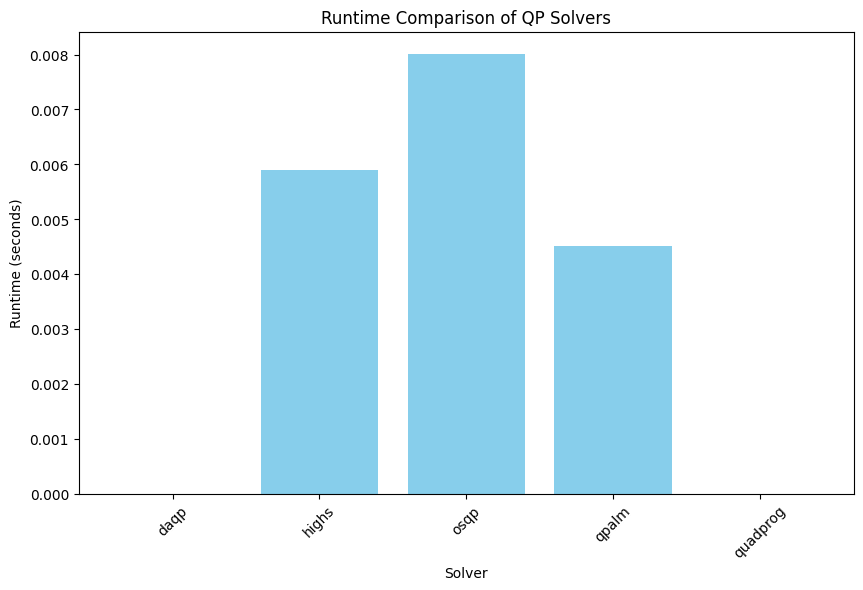

In [30]:
# --------------------------------------------------------------------------
# Print and visualize the results (separate section)
# --------------------------------------------------------------------------
print("Optimization Results:")
print("====================")
print(results_df)

# Optional: Visualize the results using a bar plot for runtime comparison
import matplotlib.pyplot as plt

# Filter out solvers that failed
successful_solvers = results_df[results_df['solution_found'] == True]

# Plot runtime comparison
plt.figure(figsize=(10, 6))
plt.bar(successful_solvers.index, successful_solvers['runtime'], color='skyblue')
plt.xlabel('Solver')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of QP Solvers')
plt.xticks(rotation=45)
plt.show()

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [42]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        X = optimization_data['return_series']
        covmat = self.covariance.estimate(X=X, inplace=False)
        self.objective = Objective(
            P=2 * covmat,
            q=np.zeros(covmat.shape[0])
        return None

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            # Check if constraints allow analytical solution
            GhAb = self.constraints.to_GhAb()
            G, h, A, b = GhAb['G'], GhAb['h'], GhAb['A'], GhAb['b']
            
            # Check for inequality constraints
            has_inequality = False
            if G is not None and G.size > 0:
                has_inequality = True
            if h is not None and h.size > 0 and not np.allclose(h, 0):
                has_inequality = True
            if has_inequality:
                return super().solve()
            
            # Check equality constraints (only budget)
            if A is None or A.shape[0] != 1:
                return super().solve()
            
            n_assets = len(self.constraints.ids)
            expected_A = np.ones((1, n_assets))
            if not np.allclose(A, expected_A):
                return super().solve()
            if not np.isclose(b[0], 1.0):
                return super().solve()
            
            # Compute analytical solution
            if 'P' not in self.objective.coefficients:
                raise ValueError("Objective coefficients 'P' not set. Call set_objective first.")
            
            cov_matrix = self.objective.coefficients['P'] / 2
            try:
                inv_cov = np.linalg.inv(cov_matrix)
            except np.linalg.LinAlgError:
                return super().solve()
            
            ones = np.ones(n_assets)
            numerator = inv_cov @ ones
            denominator = ones @ inv_cov @ ones
            if denominator == 0:
                return super().solve()
            
            w = numerator / denominator
            weights = pd.Series(w, index=self.constraints.ids)
            self.results = {
                'weights': weights.to_dict(),
                'status': True
            }
            return None
        else:
            return super().solve()

# Create a constraints object with budget constraint
# Assuming synthetic_data is defined as in part 1.a and part 1.b's ids are the same
# Example code (replace 'ids' with actual variable from synthetic data)
# ids = synthetic_data.columns.tolist()
# constraints = Constraints(ids=ids)
# constraints.add_constraint('budget', {'type': 'eq', 'coefficients': {id: 1 for id in ids}, 'rhs': 1})

# For the sake of the example, placeholder code:
constraints = Constraints(ids=['Asset1', 'Asset2', 'Asset3'])  # Replace with actual ids
constraints.add_constraint('budget', {'type': 'eq', 'coefficients': {id: 1 for id in constraints.ids}, 'rhs': 1})

# Instantiate the MinVariance class
min_var = MinVariance(constraints=constraints, solver_name='analytical')

# Prepare the optimization data (assuming synthetic_data is from part 1.a)
optimization_data = OptimizationData(return_series=synthetic_data)

# Set the objective and solve
min_var.set_objective(optimization_data)
min_var.solve()

# Print the results
print("Analytical solution weights:", min_var.results['weights'])

SyntaxError: '(' was never closed (3582609201.py, line 17)